In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, morphology, io, filters
from skimage.morphology import disk, square
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.util import img_as_ubyte
from skimage import feature

# Median filter

In [2]:
image = io.imread("texte_bruit.gif")

Le bruit dans cette image est de type "pepper-salt". Pour débruiter cette image, j'utilise le filtre de la mediane avec un disque de taille 2 qui semble donner un bon résultat. Les pixels noirs ont disparu et les lettres ne se sont pas trop déformées

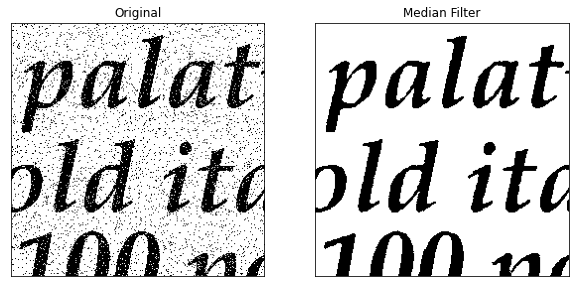

In [3]:
median_filter = filters.median(image, disk(2))

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(image, cmap='gray'), plt.title('Original')
plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(median_filter, cmap='gray'), plt.title('Median Filter')
plt.xticks([]), plt.yticks([])

plt.show()

# Segmentation

In [4]:
image_3096_HR   = io.imread("3096_HR.png")
image_37073_HR  = io.imread("37073_HR.png")
image_66053_HR  = io.imread("66053_HR.png")
image_101087_HR = io.imread("101087_HR.png")

Fonction pour transformer une image qui a 3 dimensions en 2 dimensions en somment/moyennant/maximisant la dimension des couleurs (la 3ème)

In [5]:
def transform_3D_to_2D(image3D, type="max"):
    
    if type == "max":
        image2D = np.max(image3D, axis=2)
    elif type == "mean":
        image2D = np.mean(image3D, axis=2)
    elif type == "sum":
        image2D = np.sum(image3D, axis=2)
    else:
        error("unknown type argument")
        
    return image2D

Fonctions pour segmenter une image en utilisant l'algorithme watershed. Les paramètres permettent de configurer le lisssage lors du calcul du gradient et la valeur du seuil pour calculer les marqueurs qui seront utilisés dans le watershed.

In [88]:
def segmente_image(image, smooth=2, threshold_gradient=20, transform_channel="max", compactness=0.01):
    
    image_uint8 = img_as_ubyte(image)
    
    gradients = np.zeros((image.shape))
    for i in range(image.shape[2]):
        # denoise image
        denoised = filters.rank.median(image_uint8[:,:,i], disk(2))
        # local gradient (disk(2) is used to keep edges thin)
        gradients[:,:,i] = filters.rank.gradient(denoised, disk(smooth))
    
    gradient = transform_3D_to_2D(gradients, type=transform_channel)
    
    # find continuous region  --> markers
    markers = gradient < threshold_gradient
    markers = ndi.label(markers)[0]

    # process the watershed
    labels = watershed(gradient, markers, watershed_line=True, compactness=compactness)

    return gradient, markers, labels
    

Fonctions pour affcher les différentes étapes de la segmentation par watershed

In [7]:
def display_segmentation(image, gradient, markers, labels, title=""):
    
    plt.figure(figsize=(17, 4))

    plt.subplot(141)
    plt.imshow(image, cmap="gray")
    plt.xticks([]), plt.yticks([]), plt.gca().set_aspect('auto')
    plt.title("Original")

    plt.subplot(142)
    plt.imshow(gradient)#, cmap="gray")
    plt.xticks([]), plt.yticks([]), plt.colorbar(), plt.gca().set_aspect('auto')
    plt.title("Local Gradient")

    plt.subplot(143)
    plt.imshow(markers, cmap="nipy_spectral")
    plt.xticks([]), plt.yticks([]), plt.colorbar(), plt.gca().set_aspect('auto')
    plt.title("Markers")

    plt.subplot(144)
    plt.imshow(image, cmap="gray")
    plt.imshow(labels, cmap="nipy_spectral", alpha=.7)
    plt.xticks([]), plt.yticks([]), plt.colorbar(), plt.gca().set_aspect('auto')
    plt.title("Segmented")

    plt.suptitle(title, fontweight="bold", fontsize=15)
    plt.show()

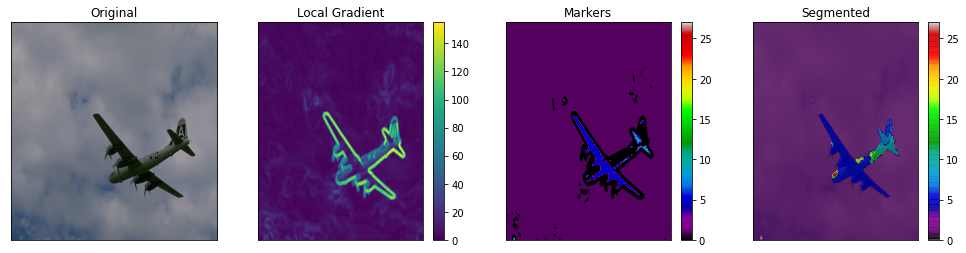

In [8]:
gradient, markers, labels = segmente_image(image_3096_HR,3,20,"max")
display_segmentation(image_3096_HR, gradient, markers, labels)

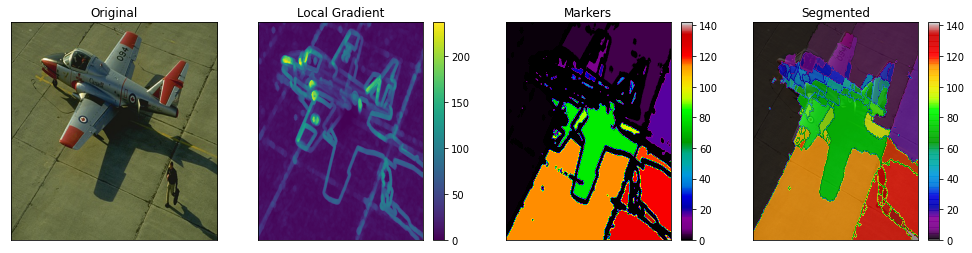

In [9]:
gradient, markers, labels = segmente_image(image_37073_HR, 4, 20)
display_segmentation(image_37073_HR, gradient, markers, labels)

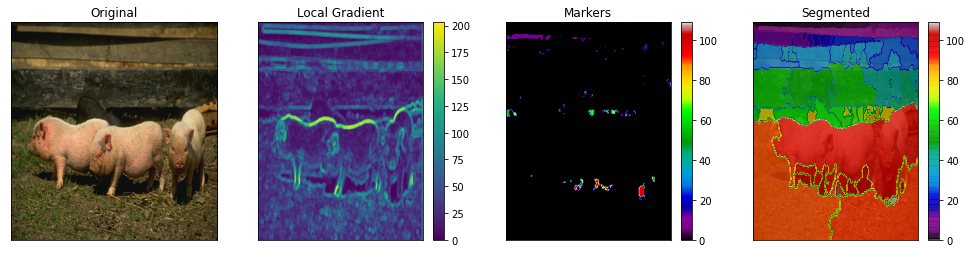

In [10]:
gradient, markers, labels = segmente_image(image_66053_HR, 3, 5)
display_segmentation(image_66053_HR, gradient, markers, labels)

In [ ]:
gradient, markers, labels = segmente_image(image_101087_HR, 2, 100, compactness=1)
display_segmentation(image_101087_HR, gradient, markers, labels)

## representation LAB   

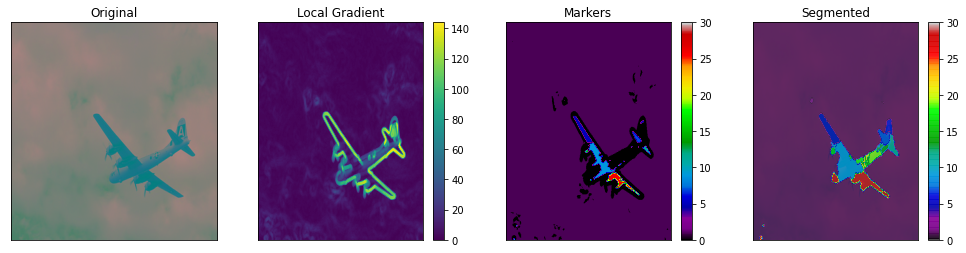

In [21]:
image_lab = color.rgb2lab(image_3096_HR)
image_lab_scaled = (image_lab + [0, 128, 128]) / [100, 255, 255]
gradient, markers, labels = segmente_image(image_lab_scaled, 3, 15,"max")
display_segmentation(image_lab_scaled, gradient, markers, labels)

# representation HSV

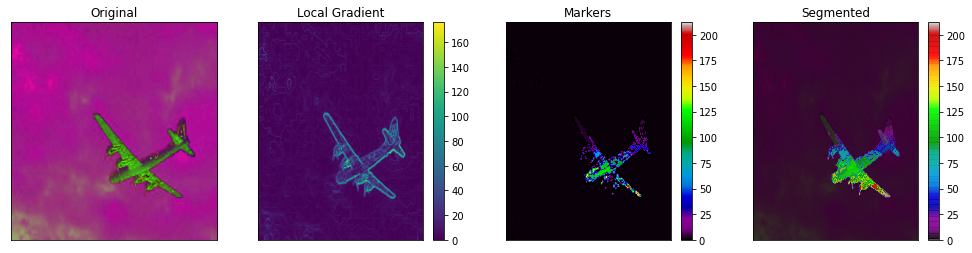

In [33]:
image_hsv = color.rgb2hsv(image_3096_HR)
gradient, markers, labels = segmente_image(image_hsv, 1, 20,"max")
display_segmentation(image_hsv, gradient, markers, labels)